
---
# Load needed libraries and functions

In [1]:

%pprint
%matplotlib inline
import sys
import os.path as osp

executable_path = sys.executable
scripts_folder = osp.join(osp.dirname(executable_path), 'Scripts'); py_folder = osp.abspath('../py')
if (scripts_folder not in sys.path): sys.path.insert(1, scripts_folder)
if (py_folder not in sys.path): sys.path.insert(1, py_folder)
from jobpostlib import (cu, time, slrcu, nu, section_classifier_utils, humanize)
from pandas import DataFrame
import pyperclip

Pretty printing has been turned OFF
======== Neo4j/5.24.2 ========
Utility libraries created in 3 seconds


---
# Parts-of-speech Prediction by Logistic Regression Algorithm

In [15]:

# Define a function to fit the classifier and store the results
from sklearn.linear_model import LogisticRegression
def fit_classifier_dict(pos_symbol, X_train_tfidf, train_data_list):
    try:
        
        # Train on initial data
        slrcu.classifier_dict[pos_symbol].fit(X_train_tfidf, train_data_list)
        nu.store_objects(
            slrcu_classifier_dict=slrcu.classifier_dict, verbose=False
        )
        
        # Build and store the prediction function
        inference_func = slrcu.build_predict_percent_fit_function(
            pos_symbol, verbose=True
        )
        slrcu.pos_predict_percent_fit_dict[pos_symbol] = inference_func
        
    except ValueError as e:
        print(f'Fitting {pos_symbol} had this error: {str(e).strip()}')
        slrcu.classifier_dict.pop(pos_symbol, None)
        slrcu.pos_predict_percent_fit_dict.pop(pos_symbol, None)


## LR Data Preparation
This stage involves preparing the LR dataset for evaluation by transforming the data with a multi-label binarizer.

In [16]:

# Train a model for each labeled POS symbol
import pandas as pd

# Parts-of-speech logistic regression model is normally built in 1 hour, 10 minutes, and 4 seconds
t1 = time.time()
    
# Check if count_vect has been saved and load it, otherwise create a new one
if nu.pickle_exists('slrcu.count_vect'):
    slrcu.count_vect = nu.load_object('slrcu.count_vect')
else:
    slrcu.count_vect = section_classifier_utils.HtmlVectorizer()

# Load or create the TF-IDF transformer
if nu.pickle_exists('slrcu.tfidf_transformer'):
    slrcu.tfidf_transformer = nu.load_object('slrcu.tfidf_transformer')
else:
    slrcu.tfidf_transformer = TfidfTransformer(
        norm='l1', smooth_idf=True, sublinear_tf=False, use_idf=True
    )

# Create the logistic regression classifiers
slrcu.classifier_dict = {}

# Initialize the percent-fit dictionary
slrcu.pos_predict_percent_fit_dict = {}

# Get the labeled training data
pos_df = cu.get_pos_relationships(verbose=False)

In [17]:

# Set aside a balanced validation dataset with 10 records for each pos_symbol
validation_data = []
training_data = []
for pos_symbol in pos_df.pos_symbol.unique():
    pos_symbol_data = pos_df[pos_df.pos_symbol == pos_symbol]
    
    # Sample 10 records for validation (or fewer if there are less than 10 available)
    validation_samples = pos_symbol_data.sample(n=min(10, len(pos_symbol_data)), random_state=42)
    validation_data.append(validation_samples)
    
    # Remaining data is for training
    training_data.append(pos_symbol_data.drop(validation_samples.index))

# Combine validation data and training data into separate data frames
pos_html_strs_df = pd.concat(validation_data)
pos_df = pd.concat(training_data)  # Remaining records in pos_df are the training data

print(f"Validation dataset: {pos_html_strs_df.shape}")
assert pos_df.pos_symbol.unique().shape[0] == pos_html_strs_df.pos_symbol.unique().shape[0], "You don't have a balanced validation set"

Validation dataset: (250, 2)


In [19]:

pos_html_strs_df.sample(min(5, pos_html_strs_df.shape[0]))

,navigable_parent,pos_symbol
46460,<b>Us</b>,H-CS
26435,<p>What’s needed- Preferred Qualifications</p>,H-PQ
47566,"<div class=""post-date"">Date:</div>",H-PD
45912,<p>Role Primary Contact (Email ID): virendra.a...,O-IP
40893,<li>Flexible working arrangements</li>,O-SP


In [18]:

# Fit-transform the Bag-of-words from these hand-labeled HTML strings
sents_list = pos_df.navigable_parent.tolist()
print(f'I have {len(sents_list):,} labeled parts of speech in the training dataset')

# Learn the vocabulary dictionary
bow_matrix = slrcu.count_vect.fit_transform(sents_list)

# Note: the shape of the Bag-of-words count vector here should be
#       html strings count * unique parts-of-speech tokens count
assert bow_matrix.shape[0] == len(sents_list), "The first dimension of the Bag-of-words count vector does not match the html strings count"
assert len(slrcu.count_vect.pos_relationships_vocab) == bow_matrix.shape[1], "The second dimension of the Bag-of-words count vector does not match the unique POS tokens count"

# Fit the TF-IDF transformer
X_train_tfidf = slrcu.tfidf_transformer.fit_transform(bow_matrix)

I have 47,949 labeled parts of speech in the training dataset


In [ ]:

# Iterate over unique POS symbols in the training data
pos_symbols = pos_df.pos_symbol.unique()
from tqdm import tqdm
progress_bar = tqdm(
    pos_symbols, total=pos_symbols.shape[0],
    desc="Train the POS Classifiers"
)
for pos_symbol in progress_bar:
    mask_series = (pos_df.pos_symbol == pos_symbol)
    train_data_list = mask_series.to_numpy()
    
    # Create a new logistic regression classifier
    if pos_symbol not in slrcu.classifier_dict:
        slrcu.classifier_dict[pos_symbol] = LogisticRegression(
            C=375.0, class_weight='balanced', max_iter=1000, penalty='l1',
            solver='liblinear', verbose=False, warm_start=True
        )
    
    # Train the classifier
    fit_classifier_dict(pos_symbol, X_train_tfidf, train_data_list)

if hasattr(slrcu, 'pos_predict_percent_fit_dict'): 
    print('predict_single is available')
else: 
    print('predict_single is not available')

duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
speech_str = f'Parts-of-speech logistic regression model built in {duration_str}'; print(speech_str)

Validation dataset size: 25
Training dataset size after split: 47949
I have 47,949 labeled parts of speech in here


Train the POS Classifiers: 100%|███████████████| 25/25 [44:29<00:00, 106.80s/it]

predict_single is available
Parts-of-speech logistic regression model built in 44 minutes and 36 seconds


In [9]:

# Prepare the comparison data
part_of_speech_dict = pos_html_strs_df.set_index('navigable_parent').pos_symbol.to_dict()
y_actual = [(pos_symbol, ) for pos_symbol in part_of_speech_dict.values()]

In [10]:

t1 = time.time()
y_lr_predicted = [(slrcu.predict_single(navigable_parent), ) for navigable_parent in part_of_speech_dict.keys()]
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Predicted labels created in {duration_str}')

Predicted labels created in 16 seconds


In [11]:

import random

# Assuming y_lr_predicted and y_actual are lists or arrays of the same length
data_length = len(y_lr_predicted)

# Generate random indices
random_indices = random.sample(range(data_length), 16)

# Use the indices to display the same samples from both arrays
y_lr_predicted_samples = [y_lr_predicted[i] for i in random_indices]
y_actual_samples = [y_actual[i] for i in random_indices]

# Print or use the samples as needed
print(f"y_lr_predicted Samples:\n{y_lr_predicted_samples}")
print(f"y_actual Samples:\n{y_actual_samples}")

y_lr_predicted Samples:
[('H-TS',), ('H-RQ',), ('H-RQ',), ('H-RQ',), ('O-PD',), ('H-PQ',), ('O-IP',), ('O-PD',), ('H-IP',), ('H-PD',), ('O-PQ',), ('H-ER',), ('O-IP',), ('H-PD',), ('O-RQ',), ('H-IP',)]
y_actual Samples:
[('H-O',), ('H-CS',), ('H-O',), ('H-RQ',), ('O-PD',), ('H-O',), ('O-IP',), ('O-PD',), ('H-JT',), ('H-PD',), ('O-O',), ('H-ER',), ('H-IP',), ('H-PD',), ('H-JT',), ('H-O',)]


In [12]:

from sklearn.preprocessing import MultiLabelBinarizer

# Create the MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# Fit and transform the y_test and y_pred sequences
y_actual_transformed = mlb.fit_transform(y_actual)
y_lr_pred_transformed = mlb.transform(y_lr_predicted)
mlb.classes_

array(['H-CS', 'H-ER', 'H-IP', 'H-JD', 'H-JT', 'H-LN', 'H-O', 'H-OL',
       'H-PD', 'H-PQ', 'H-RQ', 'H-SP', 'H-TS', 'O-CS', 'O-IP', 'O-JD',
       'O-JT', 'O-LN', 'O-O', 'O-OL', 'O-PD', 'O-PQ', 'O-RQ', 'O-SP',
       'O-TS'], dtype=object)


## LR Visualization

These metrics are particularly useful in multi-class classification problems and imbalanced datasets.

---

### 1. **Precision**
- **Definition**: Answers the question: "Of all the instances the model predicted as positive, how many were actually positive?"
- **Interpretation**: A higher precision means fewer false positives, i.e., the model is better at not misclassifying negative samples as positive.

---

### 2. **Recall (Sensitivity or True Positive Rate)**
- **Definition**: Answers the question: "Of all the actual positive instances, how many did the model correctly predict?"
- **Interpretation**: A higher recall means fewer false negatives, i.e., the model is better at capturing all the positive cases.

---

### 3. **F1-Score**
- **Definition**: The F1-score is the harmonic mean of precision and recall. It provides a single metric that balances precision and recall, especially when there is an imbalance between them.
- **Interpretation**: 
  - A high F1-score indicates a good balance between precision and recall.
  - It's particularly useful when you care about both false positives and false negatives equally.

---

### 4. **Support**
- **Definition**: Support refers to the number of actual occurrences of each class in the dataset. It is simply the count of instances for each class.

---

### Use Cases:
- **High Precision** is important when false positives are costly (e.g., spam email detection — you don't want to mark important emails as spam).
- **High Recall** is important when false negatives are costly (e.g., medical diagnosis — you don't want to miss a disease).
- **F1-Score** is used when you want a balance between precision and recall, especially in cases of imbalanced datasets.

In [31]:

# Compute the classification report
from sklearn.metrics import classification_report

pos_symbol_lr_df = DataFrame.from_dict(
    classification_report(y_actual_transformed, y_lr_pred_transformed, target_names=mlb.classes_, zero_division=0, output_dict=True),
    orient='index'
)
pos_symbol_lr_df.index.name = 'pos_symbol'
df = pos_symbol_lr_df.sort_values('recall', ascending=False)
display(df)
min_recall_pos_symbol = df.tail(1).index.values[0]
nu.store_objects(min_recall_pos_symbol=min_recall_pos_symbol)

,precision,recall,f1-score,support
pos_symbol,,,,
O-IP,0.500000,1.000,0.666667,10.0
O-TS,0.714286,1.000,0.833333,10.0
O-RQ,0.526316,1.000,0.689655,10.0
O-PD,1.000000,1.000,1.000000,10.0
O-JT,0.833333,1.000,0.909091,10.0
H-PD,1.000000,1.000,1.000000,10.0
O-JD,0.666667,1.000,0.800000,10.0
O-CS,0.625000,1.000,0.769231,10.0
H-TS,0.642857,0.900,0.750000,10.0


Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\job-hunting\saves\pkl\min_recall_pos_symbol.pkl


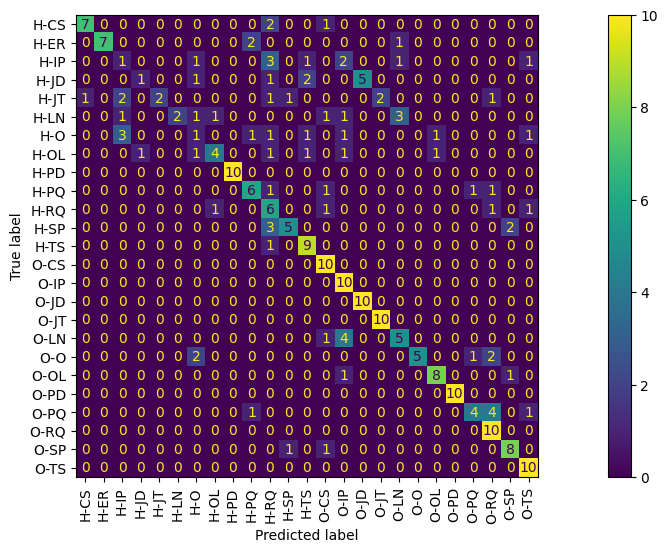

In [14]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels_list = mlb.classes_
cm = confusion_matrix(y_actual, y_lr_predicted, labels=labels_list)
fig, ax = plt.subplots(figsize=(18, 6))
cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax)
xticklabels_list = ax.set_xticklabels(labels_list, rotation='vertical')
yticklabels_list = ax.set_yticklabels(labels_list)


---
# Data Preparation
This stage involves preparing the dataset for comparison by cleaning and pre-processing the data.

In [ ]:

cypher_str = '''
    // Filter for NavigableParents nodes with an unambiguous SUMMARIZES relationship
    MATCH (np:NavigableParents)
    WHERE size([(np)<-[:SUMMARIZES]-(:PartsOfSpeech) | 1]) = 1
    
    // Find all NavigableParents nodes in the graph with an incoming SUMMARIZES relationship
    WITH np
    MATCH (np)<-[r:SUMMARIZES]-(pos:PartsOfSpeech)
    
    // Group by pos_symbol and collect navigable_parent values
    WITH pos.pos_symbol AS pos_symbol, COLLECT(np.navigable_parent) AS navigable_parents
    
    // Limit to 75 examples per pos_symbol
    WITH pos_symbol, navigable_parents[0..75] AS limited_parents
    
    // Unwind the limited list back into rows
    UNWIND limited_parents AS navigable_parent
    
    // Return the results
    RETURN
        pos_symbol,
        navigable_parent;'''
pyperclip.copy(cypher_str)
row_objs_list = []
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
if row_objs_list:
    pos_html_strs_df = DataFrame(row_objs_list)
    print(pos_html_strs_df.shape) # (75, 30)